In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784')
data= mnist['data']
target = mnist["target"]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
random_state= 42
n_splits= 5
shuffle= True
iterations= 10
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []} 
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []} 

In [4]:
kFold_handler=KFold(n_splits=n_splits, shuffle=shuffle) 
perceptron = Perceptron() 
x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    target,
                                                    test_size=0.2,
                                                    random_state=random_state)

In [5]:
def LDA_calculator(number, x_train_data, y_train_data):
    lda = LinearDiscriminantAnalysis(n_components=number)
    X_train_lda = lda.fit_transform(x_train_data, y_train_data)
    # X_test_lda = lda.transform(X_test_std)
    return X_train_lda

def perceptron_predictor(X_train_kFold, y_train_kFold, X_test_kFold, y_test_kFold):
    perceptron.fit(X_train_kFold, y_train_kFold)
    y_train_pred = perceptron.predict(X_train_kFold) 
    y_test_pred = perceptron.predict(X_test_kFold) 
    train_accuracy = accuracy_score(y_train_kFold, y_train_pred) 
    test_accuracy = accuracy_score(y_test_kFold, y_test_pred)
    return train_accuracy, test_accuracy


In [6]:
for j, n_components in enumerate([2, 3, 4, 5, 6, 7, 8, 9], start=1):
    x_train_lda= LDA_calculator(n_components, x_train, y_train)
    x_train_lda_df=pd.DataFrame(x_train_lda) 
    for i in range(iterations):
        train_accuracies = [] 
        test_accuracies = [] 
        for train_index, test_index in kFold_handler.split(x_train_lda_df, y_train): 
            X_train_kFold, X_test_kFold = x_train_lda_df.iloc[train_index], x_train_lda_df.iloc[test_index] 
            y_train_kFold, y_test_kFold = y_train.iloc[train_index], y_train.iloc[test_index] 
            train_accuracy, test_accuracy= perceptron_predictor(X_train_kFold, y_train_kFold, X_test_kFold, y_test_kFold)
            train_accuracies.append(train_accuracy) 
            test_accuracies.append(test_accuracy)
        train_accuracy_data[n_components].append(np.mean(train_accuracies))
        val_accuracy_data[n_components].append(np.mean(test_accuracies))


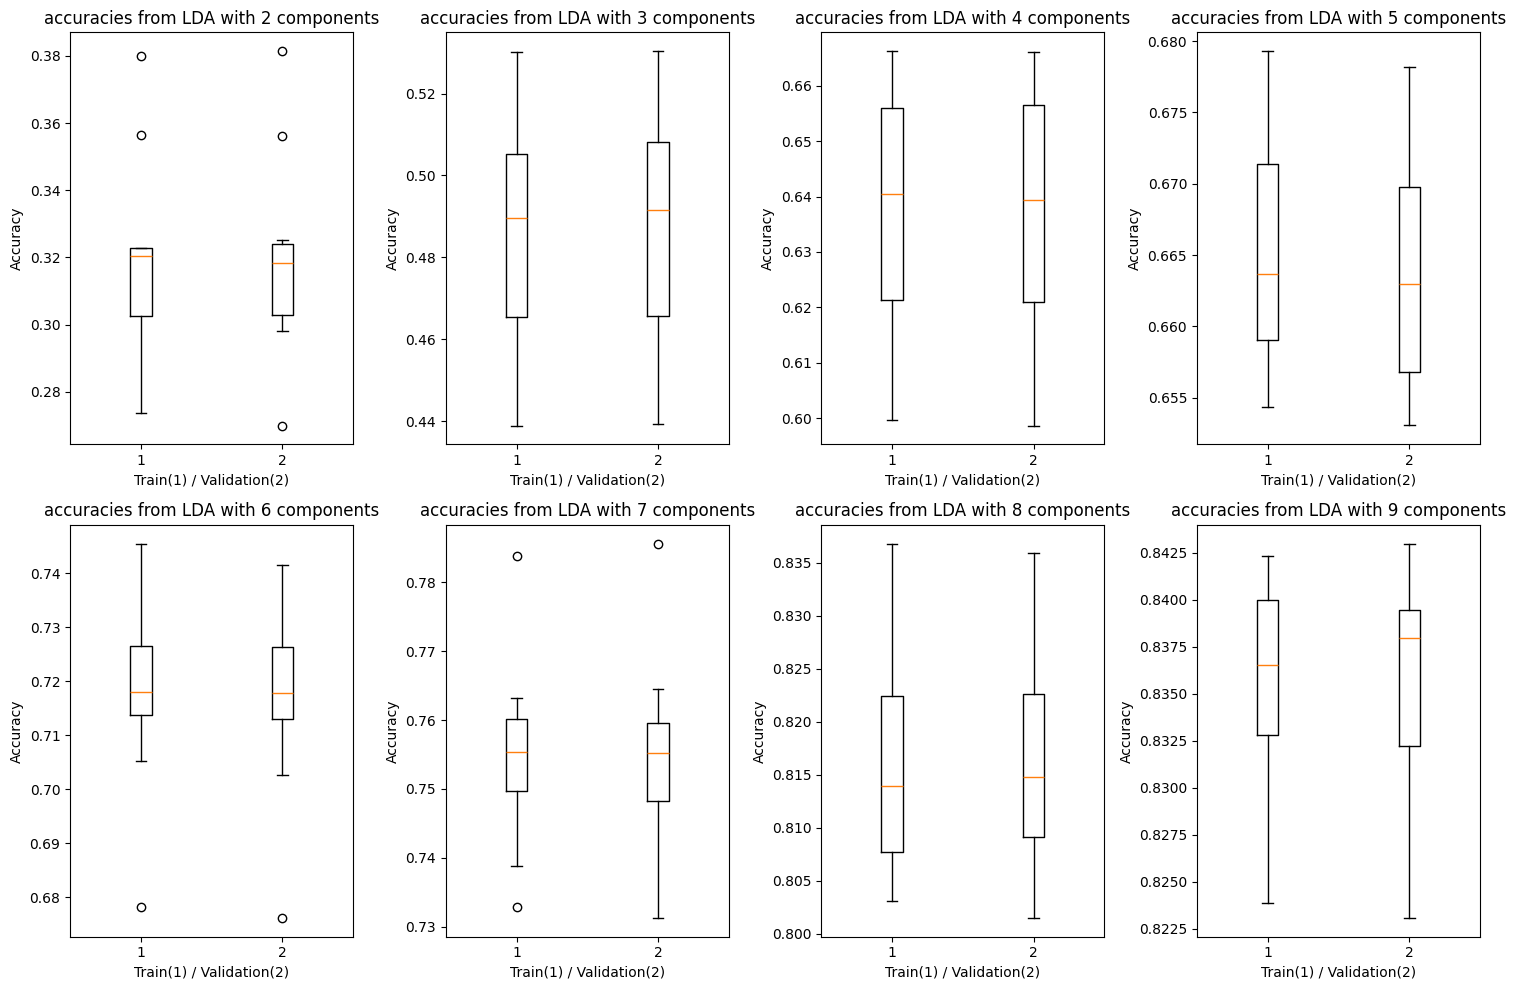

In [7]:
plt.figure(figsize=[15, 10])

for i, n_components in enumerate([2, 3, 4, 5, 6, 7, 8, 9], start=1):
    plt.subplot(2, 4, i)
    plt.boxplot([train_accuracy_data[n_components], val_accuracy_data[n_components]])
    plt.title(f'accuracies from LDA with {n_components} components')
    plt.xlabel('Train(1) / Validation(2)')
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()